In [1]:
import struct
from PIL import Image
import numpy as np

def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_hira():
    hiragana = np.zeros([71, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = 'D:/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hiragana[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                            char += 1
    np.savez_compressed("hiragana.npz", hiragana)
    
read_hira()

In [5]:
import skimage.transform
import numpy as np
from sklearn.model_selection import train_test_split

hira = np.load("hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

hira = hira/np.max(hira)

hiragana = 71
rows = 64
cols = 64

# 71 characters, 160 writers, transform image to 48*48
train_images_before = np.zeros([hiragana * 160, rows, cols], dtype=np.float32)

for i in range(71 * 160):
    train_images_before[i] = skimage.transform.resize(hira[i], (rows, cols))

arr = np.arange(71)
train_labels = np.repeat(arr, 160) # create labels

# split to train and test
train_images, test_images, train_labels, test_labels = train_test_split(train_images_before, train_labels, test_size=0.2)

np.savez_compressed("hiragana_train_images.npz", train_images)
np.savez_compressed("hiragana_train_labels.npz", train_labels)
np.savez_compressed("hiragana_test_images.npz", test_images)
np.savez_compressed("hiragana_test_labels.npz", test_labels)

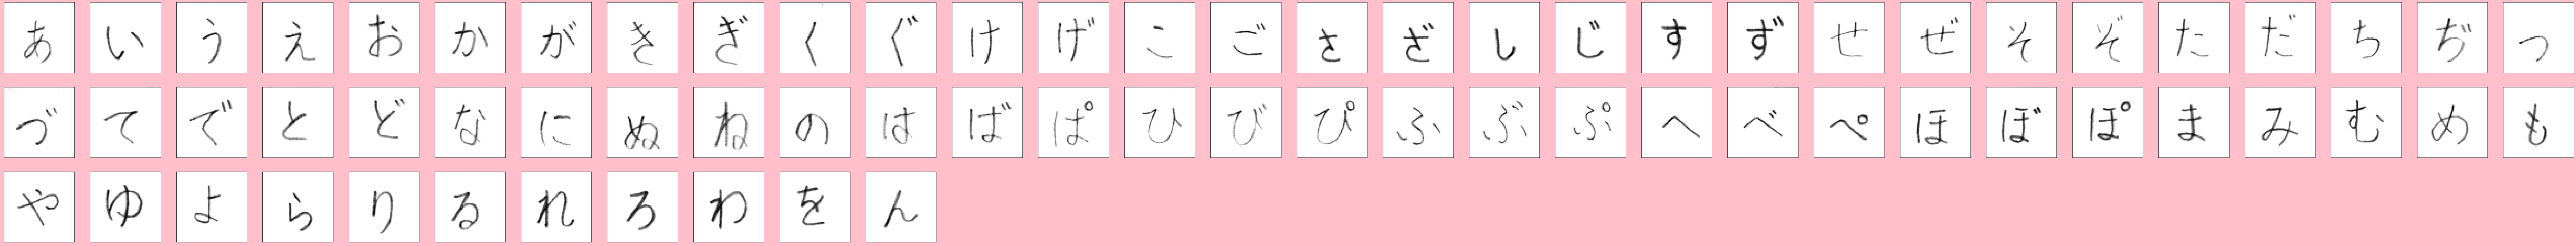

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(127,128)).patch.set_facecolor('pink')
for i in range(hiragana):
    plt.subplot(30,30,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_before[i*160], cmap=plt.cm.binary)
plt.show()

In [2]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

train_images = np.load("hiragana_train_images.npz")['arr_0']
train_labels = np.load("hiragana_train_labels.npz")['arr_0']
test_images = np.load("hiragana_test_images.npz")['arr_0']
test_labels = np.load("hiragana_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images.shape[0], 1,64,64)
  test_images2 = test_images.reshape(test_images.shape[0], 1,64,64)
  shape = (1,64,64)
else:
  train_images = train_images.reshape(train_images.shape[0], 64, 64, 1)
  test_images2 = test_images.reshape(test_images.shape[0], 64, 64, 1)
  shape = (64,64,1)

datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(train_images)

model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(220, activation='relu'),
  keras.layers.Dense(71, activation="softmax")
])

model.summary()

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=60,validation_data=(test_images2,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

test_loss, test_acc = model.evaluate(test_images2, test_labels)
print("Test Accuracy: ", test_acc)

model.save("hiragana.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dropout_1 (Dropout)         (None, 12544)            

C:\Users\Pc\AppData\Local\Temp\ipykernel_13784\2138789047.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=60,validation_data=(test_images2,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])


284/284 [==============================] - 38s 134ms/step - loss: 2.1700 - accuracy: 0.4406 - val_loss: 0.9000 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 2/60
284/284 [==============================] - 38s 135ms/step - loss: 0.8659 - accuracy: 0.7469 - val_loss: 0.4645 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 3/60
284/284 [==============================] - 38s 133ms/step - loss: 0.5588 - accuracy: 0.8309 - val_loss: 0.3211 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 4/60
284/284 [==============================] - 38s 133ms/step - loss: 0.4040 - accuracy: 0.8728 - val_loss: 0.2649 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 5/60
284/284 [==============================] - 38s 133ms/step - loss: 0.3366 - accuracy: 0.8937 - val_loss: 0.2130 - val_accuracy: 0.9344 - lr: 0.0010
Epoch 6/60
284/284 [==============================] - 38s 133ms/step - loss: 0.2726 - accuracy: 0.9145 - val_loss: 0.2242 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 7/60
284/284 [==============================] - 38s 133ms

In [3]:
import tensorflowjs as tfjs
from tensorflow import keras

model = keras.models.load_model("hiragana.h5")   # for example
tfjs.converters.save_keras_model(model, "D:/BIAI-Project-2022.github.io/tfjs_file/hiragana/")

In [2]:
import numpy as np
from tensorflow import keras

import skimage.transform as tr
from keras import backend as K


hira = np.load("hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

hira = hira/np.max(hira)

finalData = []
whatMissed =[]


for j in range(160):
	images_before = np.zeros([71, 64, 64], dtype=np.float32)
	for i in range(71):
		images_before[i] = tr.resize(hira[i*160+j],(64,64))



	if K.image_data_format() == "channels_first":
		images_before = images_before.reshape(images_before.shape[0], 1,64,64)
	else:
		images_before = images_before.reshape(images_before.shape[0], 64, 64, 1)

	model = keras.models.load_model("hiragana.h5") 
	output = model.predict(images_before)

	images_after = np.argmax(output,axis=1)


	print()
	for i in range(len(images_after)):
		if(images_after[i]!= i):
			print(j,": [",i, ": ", images_after[i],"]")
			finalData.append((i,images_after[i]))
			whatMissed.append(i)

missedCount = []
for h in range(879):
	missedCount.append((h,whatMissed.count(h)))

missedCount.sort(reverse=True, key=lambda e: e[1])
for h in range(879):
	print(missedCount[h])

3/3 [==============================] - 1s 18ms/step

3/3 [==============================] - 0s 17ms/step

3/3 [==============================] - 0s 17ms/step

3/3 [==============================] - 0s 18ms/step

3/3 [==============================] - 0s 19ms/step

3/3 [==============================] - 0s 18ms/step

3/3 [==============================] - 0s 18ms/step

3/3 [==============================] - 0s 18ms/step

3/3 [==============================] - 0s 19ms/step

3/3 [==============================] - 0s 16ms/step

3/3 [==============================] - 0s 18ms/step

3/3 [==============================] - 0s 18ms/step

3/3 [==============================] - 0s 18ms/step

3/3 [==============================] - 0s 17ms/step

3/3 [==============================] - 0s 17ms/step

3/3 [==============================] - 0s 17ms/step

3/3 [==============================] - 0s 18ms/step

3/3 [==============================] - 0s 17ms/step

3/3 [==============================] - 0s 18ms

In [5]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import skimage.transform as tr
from keras import backend as K
import matplotlib
from pathlib import Path
import seaborn as sns
import matplotlib.font_manager as fm
import statistics


hira = np.load("hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

hira = hira/np.max(hira)

heatmap_images_before = np.zeros([71*160, 64, 64], dtype=np.float32)
for j in range(160):
	for i in range(71):
		heatmap_images_before[i] = tr.resize(hira[i*160+j],(64,64))

heatmap_labels_numbers = np.arange(71)
#train_labels = np.repeat(train_labels_numbers, 160)

if K.image_data_format() == "channels_first":
  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 1,64,64)
else:
  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 64, 64, 1)

model = keras.models.load_model("hiragana.h5") 
output = model.predict(heatmap_images_before)

output= np.array(output).reshape([160,71,71]).astype(np.float32)
heatmapData = np.average(output, axis=0)



from hiraganaList import label
fpath = Path(matplotlib.get_data_path(), "fonts/ttf/NotoSansJP-Regular.otf")

sns.set_theme()
f, ax = plt.subplots(figsize=(200, 200))
res = sns.heatmap(heatmapData, annot=True, fmt=".3f", linewidths=.5, ax=ax)
res.set_xticks(np.arange(heatmapData.shape[0]),labels=label, fontsize = 30, font=fpath)
res.set_yticks(np.arange(heatmapData.shape[0]),labels=label, fontsize = 30, font=fpath)
plt.show()

355/355 [==============================] - 11s 30ms/step
